In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('paper');
sns.set_style('white');
import os
import re

### Cisteina + HNO

Chequeo todos los experimentos de un directorio, transformando guardando la concentración de HNO en uM y seteando el indice del experimento a tiempo en segundos. Cada experimento se guarda en experiments[(NO uM, Cys uM)]. Por ejemplo, el experimento NO 1uM + Cys 10 uM se encuentra en experiments[(1.0, 10.0)].

In [2]:
WD = '/Users/dbikiel/Dropbox/Compartidas/Compartida Dami - Seba/Obtencion Cte NO-tiol/Trazas Cys-NO/'
experiments = {}
for f in os.listdir(WD):
    name = re.split('_|.csv', f)[0:4]
    df = pd.read_csv( WD + f, header = None)
    df.columns = ['time','HNO']
    df.HNO = df.HNO/1000
    
    df.time = pd.to_timedelta(df.time, unit = 'seconds')
    df = df.set_index('time')
    
    if name[0] == 'NO':
        exp = (float(re.split('uM',name[1])[0]),float(re.split('uM',name[3])[0]))
    else:
        exp = (float(re.split('uM',name[3])[0]),float(re.split('uM',name[1])[0]))

    experiments[exp] = df

Grafico todos los experimentos:

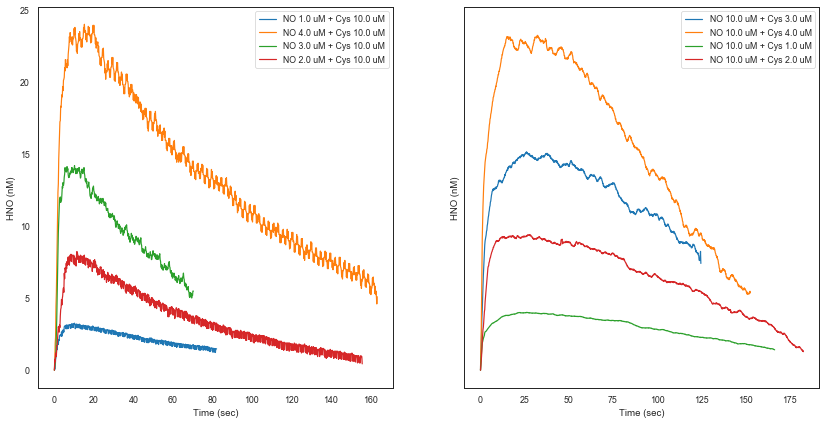

In [3]:
fig, ax = plt.subplots(1,2, figsize = (14,7), sharey= True)
for exp in experiments.keys():
    label = 'NO {0} uM + Cys {1} uM'.format(exp[0], exp[1])
    if exp[1] == 10.0:
        ax[0].plot(experiments[exp].HNO.index.total_seconds(), experiments[exp].HNO.mul(1000), label = label)
    if exp[0] == 10.0:
        ax[1].plot(experiments[exp].HNO.index.total_seconds(), experiments[exp].HNO.mul(1000), label = label)
ax[0].set(ylabel = 'HNO (nM)' , xlabel = 'Time (sec)')
ax[0].legend()
ax[1].set(ylabel = 'HNO (nM)' , xlabel = 'Time (sec)')
ax[1].legend()
plt.show()

Uso Savitzky-Golay para filtrar un poco la señal. Guardo la señal filtrada en el correspondiente dataframe

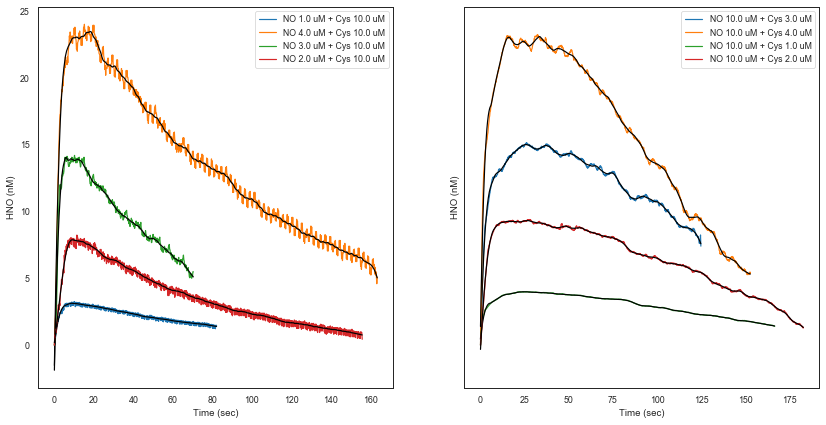

In [4]:
import scipy.signal

fig, ax = plt.subplots(1,2, figsize = (14,7), sharey= True)

for exp in experiments.keys():
    label = 'NO {0} uM + Cys {1} uM'.format(exp[0], exp[1])
    t = experiments[exp].HNO.index.total_seconds()
    data = np.array(experiments[exp].HNO.mul(1000))
    yhat = scipy.signal.savgol_filter(data, 51, 3)
    experiments[exp]['SGx1000'] = yhat

    if exp[1] == 10.0:
        ax[0].plot(t, data, label = label)
        ax[0].plot(t, yhat, 'k')
        
    if exp[0] == 10.0:
        ax[1].plot(t, data, label = label)
        ax[1].plot(t, yhat, 'k')

ax[0].set(ylabel = 'HNO (nM)' , xlabel = 'Time (sec)')
ax[0].legend()
ax[1].set(ylabel = 'HNO (nM)' , xlabel = 'Time (sec)')
ax[1].legend()
plt.show()

Grafico las derivadas de los primeros puntos de todos los experimentos:

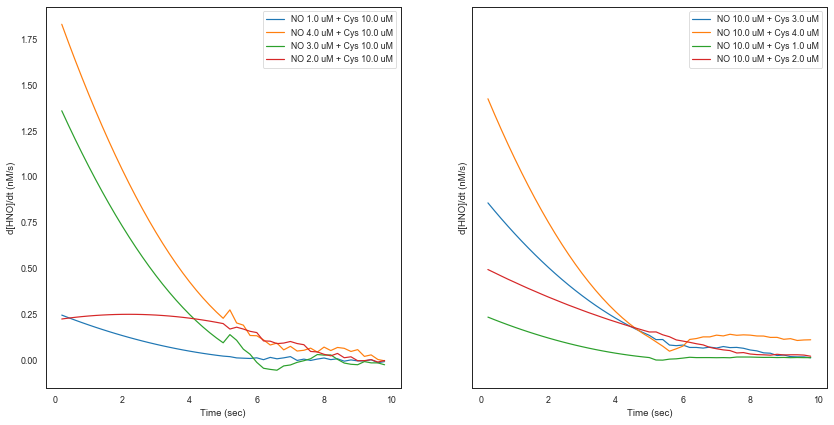

In [5]:
fig, ax = plt.subplots(1,2, figsize = (14,7), sharey= True)

NPOINTS = 50

for exp in experiments.keys():
    label = 'NO {0} uM + Cys {1} uM'.format(exp[0], exp[1])
    t = experiments[exp].HNO.index.total_seconds()
    data = np.array(experiments[exp].SGx1000.diff())

    if exp[1] == 10.0:
        ax[0].plot(t[:NPOINTS], data[:NPOINTS], label = label)
        
    if exp[0] == 10.0:
        ax[1].plot(t[:NPOINTS], data[:NPOINTS], label = label)

ax[0].set(ylabel = 'd[HNO]/dt (nM/s)' , xlabel = 'Time (sec)')
ax[0].legend()
ax[1].set(ylabel = 'd[HNO]/dt (nM/s)' , xlabel = 'Time (sec)')
ax[1].legend()
plt.show()

Fiteo exponencial a las velocidades:

In [6]:
from scipy.optimize import curve_fit

def monoexp(x, a, b, c):
    return a * np.exp(-b *x) + c

def linear(x, a, b):
    return a*x + b

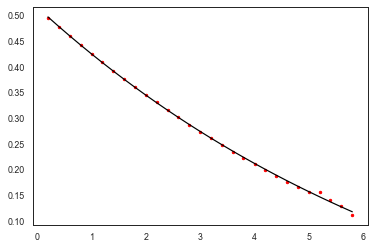

velocidad inicial: 0.5161663615511225 nM/s


array([ 0.76594906,  0.1262863 , -0.2497827 ])

In [7]:
NINI = 1
NPOINTS = 30
xdata = experiments[(10.0, 2.0)].index.total_seconds()[NINI:NPOINTS]
ydata = experiments[(10.0, 2.0)].SGx1000.diff()[NINI:NPOINTS]

popt, pcov = curve_fit(monoexp, xdata, ydata, p0 = [1,0.4,0.1])
#popt, pcov = curve_fit(linear, xdata, ydata)

plt.plot(xdata, ydata,'r.')
plt.plot(xdata, monoexp(xdata, *popt),'k')
#plt.plot(xdata, linear(xdata, *popt),'k')
plt.show()

print('velocidad inicial: {0} nM/s'.format(monoexp(0, *popt)))
popt

Obtengo las velocidades iniciales para cada experimento

In [8]:
NO_Cys10_v0 = [0.267, np.nan, 1.48, 1.97]
NO_Cys10_k = [0.239, np.nan, 0.261, 0.25]
Cys_NO10_v0 = [0.257, 0.52, 0.91, 1.54]
Cys_NO10_k = [0.268, 0.12, 0.21, 0.27]

In [9]:
(np.array(Cys_NO10_v0)/1000)/np.array([10, 20, 30, 40])

array([2.57000000e-05, 2.60000000e-05, 3.03333333e-05, 3.85000000e-05])

Que podemos concluir de aca...

La formacion de HNO es:

dHNO = -16[HNO]^2 - 5.6[HNO][NO] - 3[HNO][RSH] + k5[X]

donde X es el supuesto intermediario que se forma por la reaccion de NO y RSH. Su velocidad de formacion:

dX = k1[NO][RSH] - k6[RSH][X] - k5[X]

Vamos a realizar las siguientes suposiciones:
1) X está en estado estacionario, por lo tanto su valor es: [X] = k1[NO][RSH]/(k6[RSH] + k5)

Bajo estas condiciones, la velocidad de formación de HNO es:

dHNO = -16[HNO]^2 -5.6[HNO][NO] - 3[HNO][RSH] + k5k1[NO][RSH]/(k6[RSH] + k5)

mas aun, vamos a suponer que a tiempos cortos, HNO es despreciable, por lo que la velocidad inicial es:
v0 =  k5k1[NO][RSH]/(k6[RSH] + k5)

In [10]:
def func(NO_Cys, k1, k5, k6):
    NO, Cys = NO_Cys
    return k5*k1*NO*Cys/(k6*Cys + k5)

def func2(NO_Cys, k1):
    NO, Cys = NO_Cys
    return k1*NO*Cys

In [11]:
v0 = np.array([0.267, 1.48, 1.97, 0.257, 0.52, 0.91, 1.54])/1000
NO = np.array([1.0, 3.0, 4.0, 10.0, 10.0, 10.0, 10.0])
Cys = np.array([10.0, 10.0, 10.0, 1.0, 2.0, 3.0, 4.0])

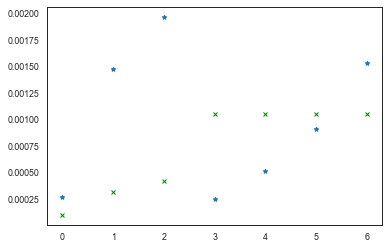

array([6.45810974e-01, 6.75123229e-01, 4.14013857e+03])

In [12]:
popt, pcov = curve_fit(func, (NO, Cys), v0, p0 = [1, 1, 1], bounds=(0, np.inf))
plt.plot(func((NO,Cys), *popt), 'gx')
plt.plot(v0,'*')
plt.show()
popt

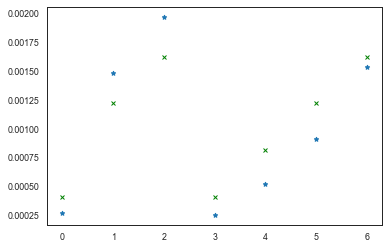

array([4.06688104e-05])

In [13]:
popt, pcov = curve_fit(func2, (NO, Cys), v0, bounds=(0, np.inf))
plt.plot(func2((NO,Cys), *popt), 'gx')
plt.plot(v0,'*')
plt.show()
popt

Con estos resultados, parecería que la k6 es despreciable. Si eliminamos este valor, la k1 es aproximadamente 4e5 M-1 s-1. Tratando de usar este valor para obtener k5 del ajuste total del mecanismo, 